In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [2]:
# Utility functions 
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# Load Data

In [3]:
df = pd.read_csv("ames.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal,189900


# Visualize the relationship between features

In [4]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
df.melt(id_vars="SalePrice", value_vars=features)

,SalePrice,variable,value
0,215000,YearBuilt,1960.0
1,105000,YearBuilt,1961.0
2,172000,YearBuilt,1958.0
3,244000,YearBuilt,1968.0
4,189900,YearBuilt,1997.0
...,...,...,...
8785,142500,ScreenPorch,0.0
8786,131000,ScreenPorch,0.0
8787,132000,ScreenPorch,0.0
8788,170000,ScreenPorch,0.0


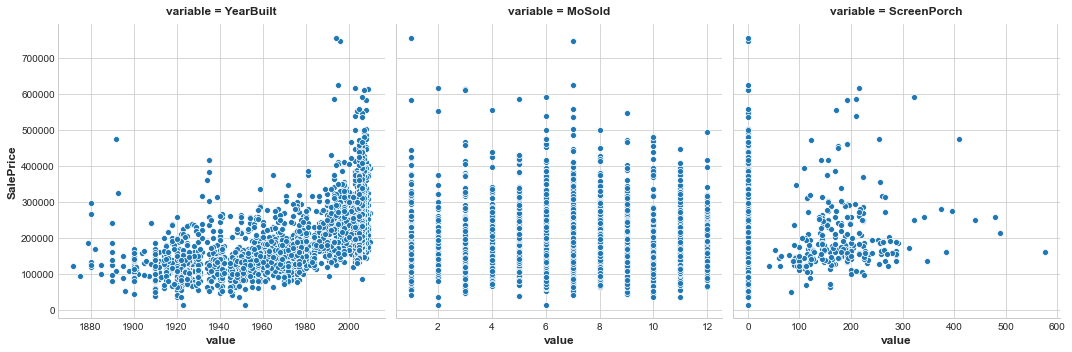

In [5]:
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

# Examine MI Scores

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


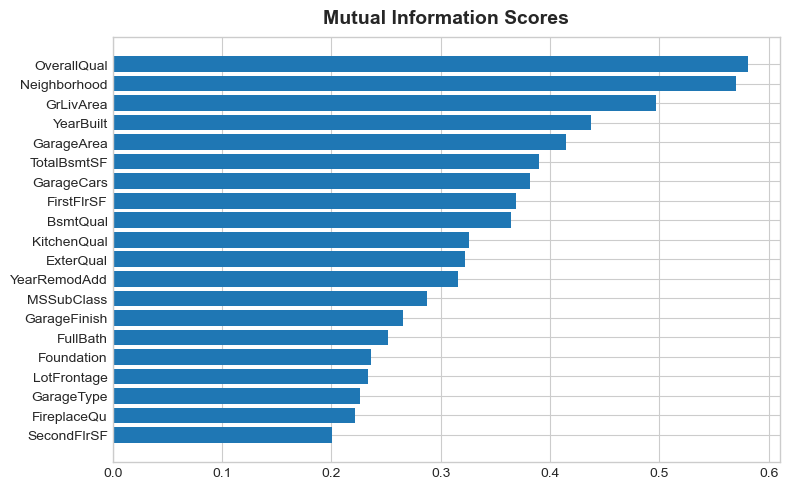

In [6]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

The BldgType feature didn't get a very high MI score. A plot confirms that the categories in BldgType don't do a good job of distinguishing values in SalePrice (the distributions look fairly similar, in other words):

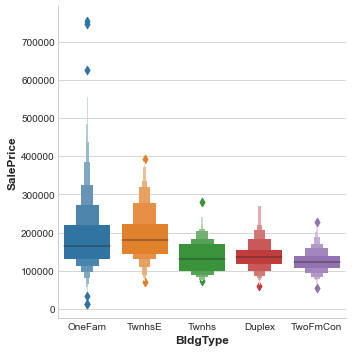

In [7]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

# Discover Interactions

Still, the type of a dwelling seems like it should be important information. Investigate whether BldgType produces a significant interaction with GrLivArea and MoSold

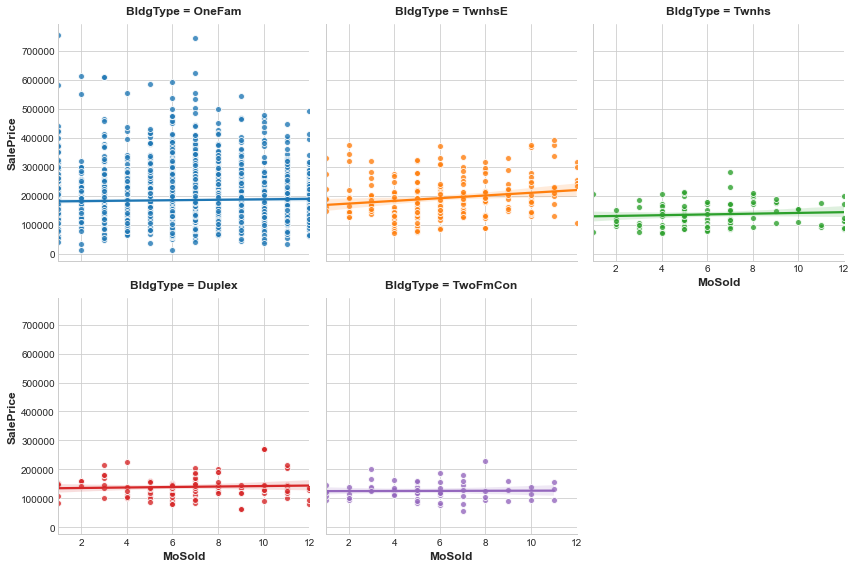

In [8]:
sns.lmplot(
    x="MoSold", y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines for MoSold are almost all the same. This feature hasn't become more informative for knowing BldgType.

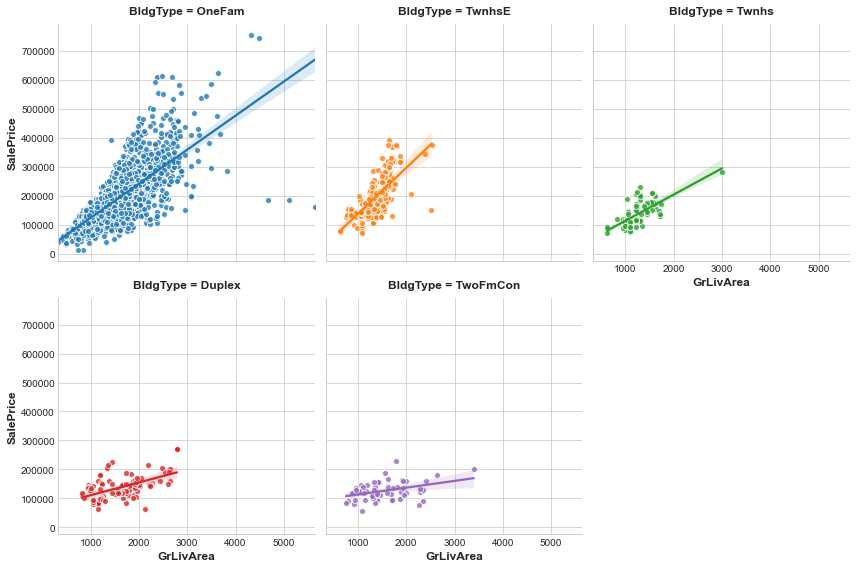

In [9]:
sns.lmplot(
    x="GrLivArea", y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category to the next indicates an interaction effect. Since knowing BldgType tells us more about how GrLivArea relates to SalePrice, we should consider including BldgType in our feature set.